In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import tqdm as tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
root_dir = "D:/dataset/"
os.listdir(root_dir)

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [3]:
foggy = "D:/dataset/foggy"
shine = "D:/dataset/shine"
rainy = "D:/dataset/rainy"
sunrise = "D:/dataset/sunrise"
cloudy  = "D:/dataset/cloudy"
img_size = 224

In [4]:
print(f"Foggy: {len(os.listdir(foggy))}")
print(f"Shine: {len(os.listdir(shine))}")
print(f"Rainy: {len(os.listdir(rainy))}")
print(f"sunrise: {len(os.listdir(sunrise))}")
print(f"cloudy: {len(os.listdir(cloudy))}")

Foggy: 300
Shine: 250
Rainy: 300
sunrise: 350
cloudy: 300


In [5]:
x = []
y = []
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)

        img = load_img(full_path, target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)

        x.append(img)
        y.append(dir_name)
    return x,y

In [6]:
x,y = create_dataset(foggy,"foggy")
x,y = create_dataset(shine,"shine")
x,y = create_dataset(rainy,"rainy")
x,y = create_dataset(sunrise,"sunrise")
x,y = create_dataset(cloudy,"cloudy")

100%|██████████| 300/300 [00:00<00:00, 321.08it/s]


In [7]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((1500, 1, 224, 224, 3), (1500,))

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [10]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [11]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [12]:
y_train_lb.shape,y_test_lb.shape

((1200, 5), (300, 5))

In [22]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

In [23]:
for layer in vgg.layers:
    layer.trainable = False

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model =Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.keras",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [29]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [4800 1200]


In [30]:
batch_size=32
history =  model.fit(x_train,y_train_lb,epochs=15,validation_data=(x_test,y_test_lb),
                     batch_size=32 ,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4996 - loss: 1.4151
Epoch 1: val_accuracy improved from -inf to 0.77667, saving model to vgg19.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 370s 10s/step - accuracy: 0.5035 - loss: 1.4038 - val_accuracy: 0.7767 - val_loss: 0.6265
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8960 - loss: 0.3327
Epoch 2: val_accuracy improved from 0.77667 to 0.87000, saving model to vgg19.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.8965 - loss: 0.3313 - val_accuracy: 0.8700 - val_loss: 0.4035
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9686 - loss: 0.1662
Epoch 3: val_accuracy improved from 0.87000 to 0.89000, saving model to vgg19.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 362s 10s/step - accuracy: 0.9684 - loss: 0.1663 - val_accuracy: 0.8900 - val_loss: 0.3495
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9775 - loss: 0.1188
Epoch 4: val_accuracy improved from 0.89000 to 0.90000, saving model

In [31]:
loss,accuracy = model.evaluate(x_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")  

10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.8943 - loss: 0.3132
Loss: 0.3192790746688843
Accuracy: 0.8966666460037231


In [32]:
y_pred = np.argmax(model.predict(x_test), axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step


In [33]:
y_pred[:15]

array([4, 0, 3, 3, 3, 4, 4, 2, 0, 1, 0, 0, 1, 0, 1], dtype=int64)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        64
           1       0.84      0.88      0.86        56
           2       0.83      0.92      0.87        52
           3       0.90      0.87      0.89        54
           4       0.95      0.95      0.95        74

    accuracy                           0.90       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.90      0.90      0.90       300



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

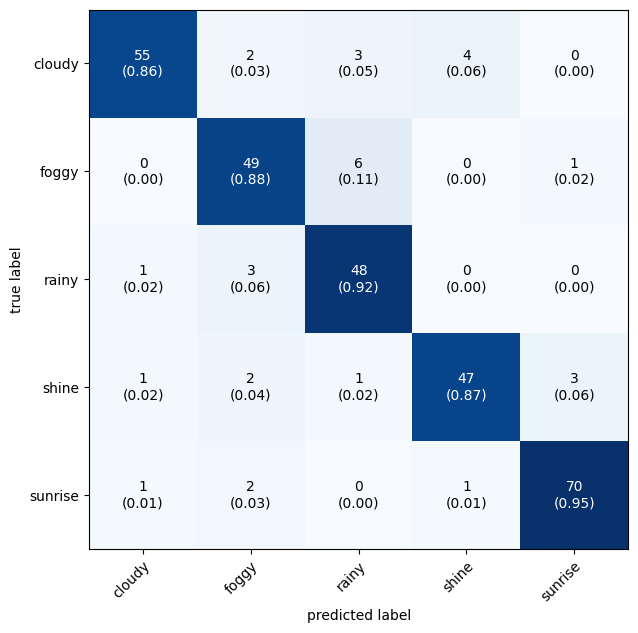

In [35]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cloudy","foggy","rainy","shine","sunrise"],
                      show_normed = True)

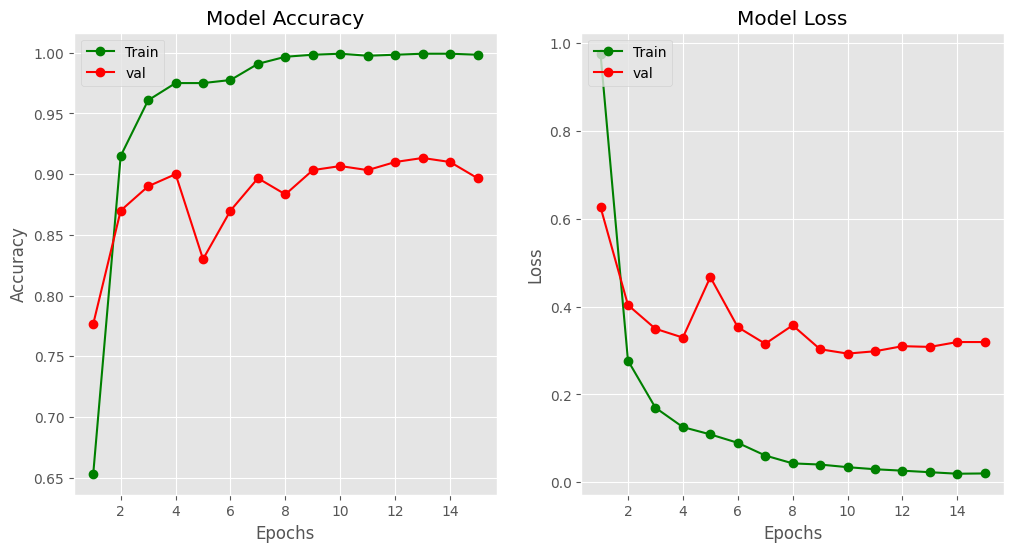

In [36]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

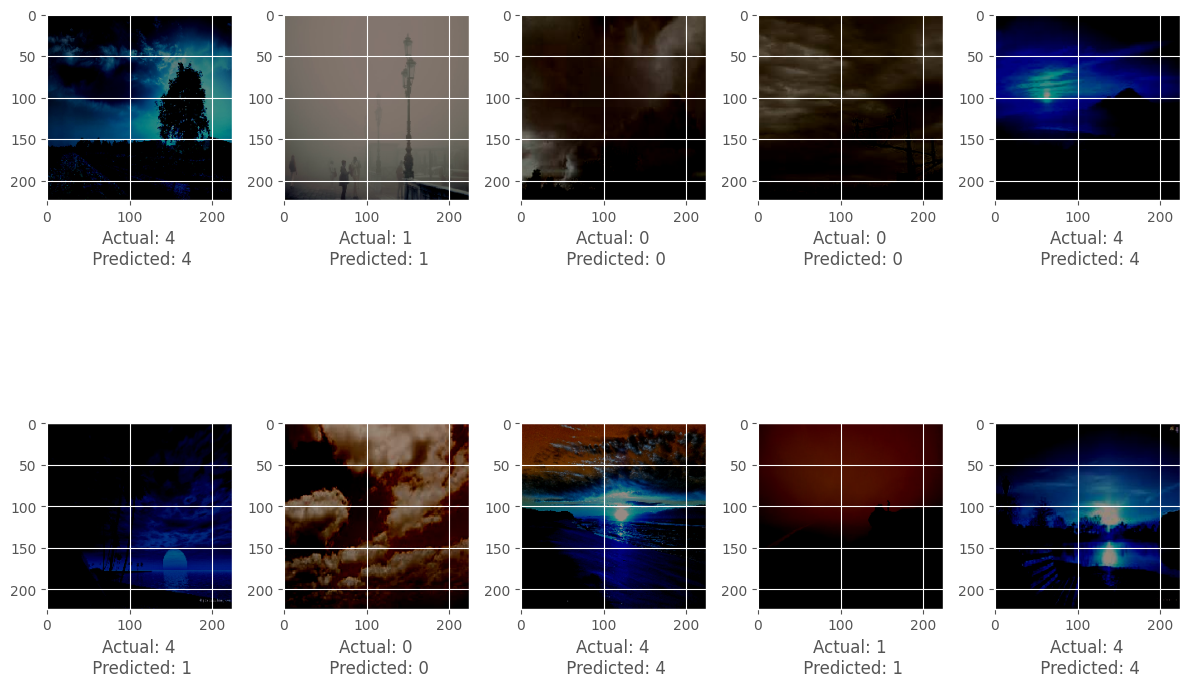

In [37]:
plt.figure(figsize=(12,9))
plt.style.use("ggplot")
for i in range(10):
    sample = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {y_pred[sample]}")
    
plt.tight_layout()    
plt.show() 